In [14]:
# Library Imports
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

import numpy as np
np.set_printoptions(precision=4)
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import os
from time import sleep

In [15]:
# Read the .stl files
package_dir = os.path.abspath(os.getcwd())
urdf_path = package_dir + '/model/fingeredu.urdf'

In [16]:
# Build the robot 
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_path, package_dir)
data = model.createData()

In [17]:
# Display the visual of the robot
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel()
q0 = pin.neutral(model)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [18]:
# Get the FrameID of the EOAT
EOAT_ID = model.getFrameId('finger_tip_link')

In [19]:
# Computing Forward Kinematics
def compute_ForwardKinematics(model, data, q):
    pin.framesForwardKinematics(model, data, q)
    pos = np.array(data.oMf[EOAT_ID].translation)
    return pos

In [20]:
# Compute the Jacobian
def compute_Jacobian(model, data, q):
    pin.computeJointJacobians(model, data, q)
    return pin.getFrameJacobian(model, data, EOAT_ID, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)[:3]

In [21]:
# Trajectory Planning for Point-to-Point(P2P) Motion
def P2P_Planner(model, data, joint_pos, goal_pos, interpolation='joint', track_EOAT = True):
    # Initiate Callers
    q = joint_pos
    y_target = goal_pos.copy()
    init_y = compute_ForwardKinematics(model, data, q)
    Error = goal_pos - init_y

    # Constants
    W = 1e-4 * np.eye(3)

    # Track EOAT
    if track_EOAT:
        EOAT = []
        EOAT.append(init_y)

    # HyperParams-> Needs to be tuned for large P2P Motion
    if interpolation=='joint':
        max_steps = 100
        smooth = 0.1
    if interpolation=='linear':
        max_steps = 1000
        smooth = 0.9

    for i in range(1, max_steps):
        y = compute_ForwardKinematics(model, data, q)
        J = compute_Jacobian(model, data, q) 

        # Compute Error
        Error = goal_pos - y

        if interpolation=='joint':
            pass
        if interpolation=='linear':
            y_target = init_y + (i/max_steps)*(goal_pos-y)

        # Compute Step Angle
        q += smooth * np.linalg.inv(J.T @ J + W) @ J.T @ (y_target - y)
        viz.display(q)
        sleep(2e-3)

        if track_EOAT:
            EOAT.append(y)
    
    if track_EOAT:
        return q, EOAT
    else:
        return q

In [22]:
# Point based Trajectory Planner
def Trajectory_Planner(model, data, joint_pos, Point_List, track_EOAT = True):
    q = joint_pos

    # Track EOAT
    if track_EOAT:
        EOAT = []

    # Invoke P2P_Planner for each Point
    for i, point in enumerate(Point_List):
        q, trace_points = P2P_Planner(model, data, q, point)
        EOAT.append(trace_points)

    if track_EOAT:
        return np.concatenate(EOAT)

In [23]:
q = np.array([0, np.pi/4, np.pi/4])
viz.display(q)
sleep(2)

trajectory_points = Trajectory_Planner(model, data, q, [np.zeros(3), 0.1*np.ones(3)])

In [24]:
# Plotter of EOAT Position 
def plot_EOATPosition(trace_points):
    ax = plt.axes(projection='3d')
    ax.plot3D(trace_points[:,0],trace_points[:,1],trace_points[:,2], c='red', label='Trajectory')
    ax.legend(loc='best')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    ax.zaxis.set_tick_params(labelsize=7)

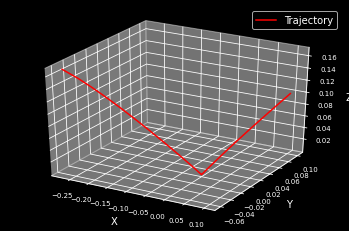

In [25]:
plot_EOATPosition(trajectory_points)